In [3]:
#!pip install --user --upgrade ibmseti

Requirement already up-to-date: ibmseti in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/.local/lib/python2.7/site-packages
Requirement already up-to-date: requests>=2.9.1 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/.local/lib/python2.7/site-packages (from ibmseti)
Requirement already up-to-date: numpy>=1.10 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/.local/lib/python2.7/site-packages (from ibmseti)
Requirement already up-to-date: six>=1.10.0 in /usr/local/src/bluemix_jupyter_bundle.v46/notebook/lib/python2.7/site-packages (from ibmseti)
Requirement already up-to-date: scipy>=0.14.0 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/.local/lib/python2.7/site-packages (from ibmseti)
Requirement already up-to-date: idna<2.6,>=2.5 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sbb5-1ce73915b4fc6f-b77eb2b8b2db/.local/lib/python2.7/site-packages (fro

In [4]:
#If you are running this in IBM Apache Spark (via Data Science Experience)
base_url = 'https://dal05.objectstorage.service.networklayer.com/v1/AUTH_cdbef52bdf7a449c96936e1071f0a46b'

In [5]:
#Defining a local data folder to dump data
import os
import ibmseti
import zipfile

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#Note for hackathon participants that use the Spark Enterprise Cluster: You MUST define a unique local data folder
# to save your work in order to avoid colliding with other teams using the enterprise clusters.
mydatafolder = 'my_team_name_data_folder'
if os.path.exists(mydatafolder) is False:
    os.makedirs(mydatafolder)

In [6]:
basic_container = 'simsignals_basic_v2'
basic4_zip_file = 'basic4.zip'

In [7]:
#Use local `curl` command to GET the basic4 zip file and save to local data folder
os.system('curl {}/{}/{} > {}'.format(base_url, basic_container, basic4_zip_file, mydatafolder + '/' + basic4_zip_file))

0

In [8]:
!ls -al my_team_name_data_folder/basic4.zip

-rw------- 1 sbb5-1ce73915b4fc6f-b77eb2b8b2db users 1157840757 Jun 10 13:15 my_team_name_data_folder/basic4.zip


In [9]:
zz = zipfile.ZipFile(mydatafolder + '/' + 'basic4.zip')
basic4list = zz.namelist()

In [10]:
len(basic4list)

4000

In [11]:
index=3200
firstfile = basic4list[index]
print firstfile

ced97297-1fb7-4647-b6e9-e8c5d490a922.dat


In [12]:
#While it's somewhat trivial to read these data, the ibmseti.compamp.SimCompamp 
#class will extract the JSON header and the complex-value time-series data for you.
aca = ibmseti.compamp.SimCompamp(zz.open(firstfile).read()) #SimCompAmp = Simulated Complex Amplitude

In [13]:
# This data file's classification and UUID
aca.header()

{u'signal_classification': u'narrowbanddrd',
 u'uuid': u'ced97297-1fb7-4647-b6e9-e8c5d490a922'}

In [14]:
print len(aca.header()) #header, self.data = data.split('\n',1) #From /ibmseti/compamp.py
print len(aca.data) #Double of above number, since complaex number has two parts, a real and an imaginary part
print aca.complex_data().shape
#print aca.shape #AttributeError: 'SimCompamp' object has no attribute 'shape'

2
393216
(196608,)


In [15]:
# ibmseti.compamp.SimCompamp has a method to calculate the spectrogram for you 
# without any signal processing applied to the time-series data
spectrogram = aca.get_spectrogram()
spectrogram.shape

(32, 6144)

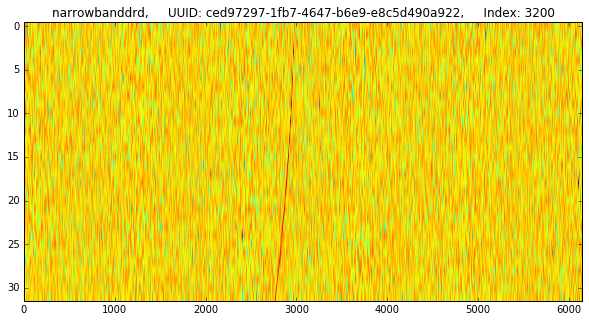

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log(spectrogram),  aspect = 0.5*float(spectrogram.shape[1]) / spectrogram.shape[0])
plt.title('%s,     UUID: %s,     Index: %s'%(aca.header()['signal_classification'],aca.header()['uuid'],index))

In [17]:
# You don't need to use ibmseti python package to calculate the spectrogram for you.
# This is especially important if you want to apply some signals processing to the 
# time-series data before you create your spectrogram
complex_data = aca.complex_data()
#complex valued time-series
complex_data

array([ 31.0967865 -3.02380872j,  21.0967865 +2.97619128j,
         9.0967865 +2.97619128j, ...,  -6.9032135+11.97619152j,
         1.0967865-18.02380943j, -27.9032135 -5.02380896j], dtype=complex64)

In [18]:
complex_data = complex_data.reshape(32, 6144)
#complex_data

In [19]:
#Apply a Hanning Window
complex_data = complex_data * np.hanning(complex_data.shape[1])
#complex_data

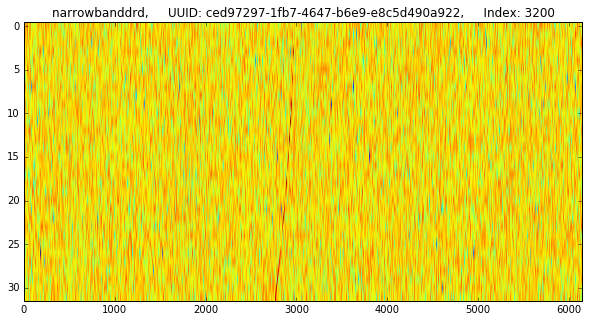

In [20]:
# Build Spectogram & Plot
cpfft = np.fft.fftshift( np.fft.fft(complex_data), 1)
spectrogram = np.abs(cpfft)**2

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(np.log(spectrogram), aspect = 0.5*float(spectrogram.shape[1]) / spectrogram.shape[0])
#ax.imshow(spectrogram, aspect = 0.5*float(spectrogram.shape[1]) / spectrogram.shape[0])
plt.title('%s,     UUID: %s,     Index: %s'%(aca.header()['signal_classification'],aca.header()['uuid'],index))

In [21]:
print spectrogram.shape
#print type(spectrogram) #<type 'numpy.ndarray'>

(32, 6144)


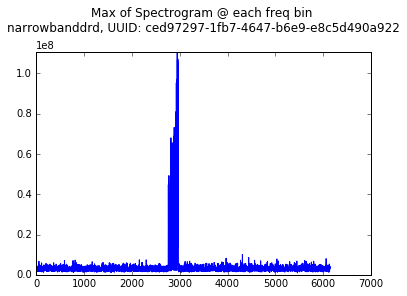

In [22]:
plt.plot(spectrogram.max(axis=0))
plt.ylim([0,spectrogram.max()])
plt.title('Max of Spectrogram @ each freq bin \n%s, UUID: %s\n'%(aca.header()['signal_classification'],aca.header()['uuid']))

In [23]:
spectrogram.max()

110824322.95213531

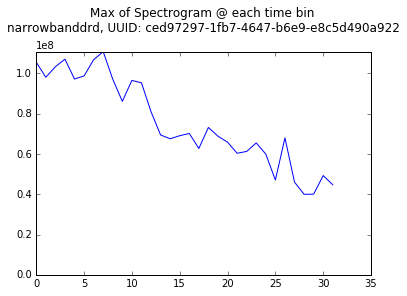

In [24]:
plt.plot(spectrogram.max(axis=1))
plt.ylim([0,spectrogram.max()])
plt.title('Max of Spectrogram @ each time bin \n%s, UUID: %s\n'%(aca.header()['signal_classification'],aca.header()['uuid']))

In [25]:
#plt.plot(spectrogram[0,:])
#plt.title('Signal at one time bin \n%s, UUID: %s\n'%(aca.header()['signal_classification'],aca.header()['uuid']))

In [26]:
MaxAmps = spectrogram.max(axis=1)
MaxAmps_Freq = spectrogram.argmax(1)
MaxAmps_Time = np.arange(31,-1,-1)

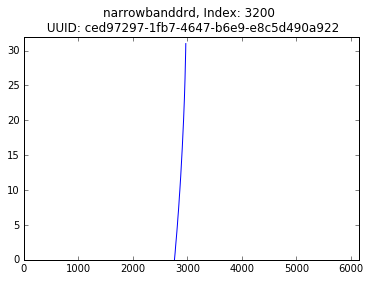

In [27]:
plt.plot(MaxAmps_Freq, MaxAmps_Time)
plt.xlim([0,6144])
plt.ylim([0,32])
plt.title('%s, Index: %s \n UUID: %s'%(aca.header()['signal_classification'],index,aca.header()['uuid']))

In [28]:
import scipy
from scipy import stats

In [29]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(MaxAmps_Freq, MaxAmps_Time)

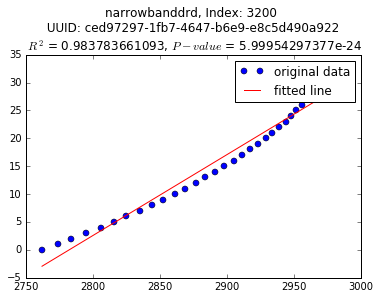

In [30]:
plt.plot(MaxAmps_Freq, MaxAmps_Time, 'o', label='original data')
plt.plot(MaxAmps_Freq, intercept + slope*MaxAmps_Freq, 'r', label='fitted line')
plt.legend(loc=1)
plt.title('%s, Index: %s \n UUID: %s \n $R^2$ = %s, $P-value$ = %s'%(aca.header()['signal_classification'],
            index,aca.header()['uuid'],r_value,p_value))  
plt.show()

In [31]:
!ls -a

.
..
core.20170524.165605.3307.0001.dmp
core.20170525.000839.29830.0001.dmp
core.20170528.162218.28855.0001.dmp
core.20170528.194328.8797.0001.dmp
core.20170529.032401.13718.0001.dmp
filename.png
heapdump.20170524.165605.3307.0002.phd
heapdump.20170525.000839.29830.0002.phd
heapdump.20170528.162218.28855.0002.phd
heapdump.20170528.194328.8797.0002.phd
heapdump.20170528.194955.8797.0005.phd
heapdump.20170529.010127.8797.0008.phd
heapdump.20170529.020254.8797.0011.phd
heapdump.20170529.032401.13718.0002.phd
javacore.20170524.165605.3307.0003.txt
javacore.20170525.000839.29830.0003.txt
javacore.20170528.162218.28855.0003.txt
javacore.20170528.194328.8797.0003.txt
javacore.20170528.194955.8797.0006.txt
javacore.20170529.010127.8797.0009.txt
javacore.20170529.020254.8797.0012.txt
javacore.20170529.032401.13718.0003.txt
my_team_name_data_folder
Snap.20170524.165605.3307.0004.trc
Snap.20170525.000839.29830.0004.trc
Snap.20170528.162218.28855.0004.trc
Snap.20170528.194328.8797.0004.trc
Snap.20

In [ ]:
# @hidden_cell
credentials_1 = {
  'auth_url':'https://identity.open.softlayer.com',
  'project':'object_storage_205c4f18_fee1_4d57_8b3d_a796f1125e04',
  'project_id':'aa22daa1070347848cbdd103df44dfbb',
  'region':'dallas',
  'user_id':'47404e1c8d8b46eeb84f45cff881bae0',
  'domain_id':'e15e35e73d58464389fbf14d81b52f20',
  'domain_name':'1318277',
  'username':'member_cdd310eeb7086f719fbe75a724578af5086579cb',
  'password':"""ws_.~Uw#64cRS_L#""",
  'container':'SETI1',
  'tenantId':'undefined',
  'filename':'signaldb_joined_with_all_candidate_aca_events_2013_2015.csv'
}